In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
outputbasefolder = '../../../../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribble/Outputs/Human_DLPFC/Report'

In [11]:
co_ordinates = pd.read_csv('../Coordinates/coordinates.csv',index_col=0,header=0)
manual_annotation = pd.read_csv('../manual_annotations.csv',index_col=0,header=0)
pc_s = pd.read_csv('../Principal_Components/CSV/15_pcs.csv',index_col=0,header=0)
mclust_init = pd.read_csv('../../../../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribble/Outputs/Human_DLPFC/151673/test_1/Outputs/Cluster_Labels_15final.csv',index_col=0,header=0)
combined_df = pd.concat([co_ordinates,manual_annotation,mclust_init,pc_s],axis=1)
combined_df['label'].fillna(-1,inplace=True)
# combined_df = combined_df.dropna(subset=['label'])
# combined_df['label'] = combined_df['manual_annotation']
combined_df.dropna(inplace=True)
# combined_df['label'] = combined_df['label'].astype(int)
# combined_df.drop(combined_df[combined_df['label']==40].index,inplace=True)


In [18]:
color_map = {
    "WM":"yellow",
    "L1":"blue",
    "L2":"green",
    "L3":"red",
    "L4":"purple",
    "L5":"orange",
    "L6":"grey",
    "L7":"pink",
    "undetected":"black",
}
combined_df['color'] = combined_df['manual_annotation'].map(color_map)

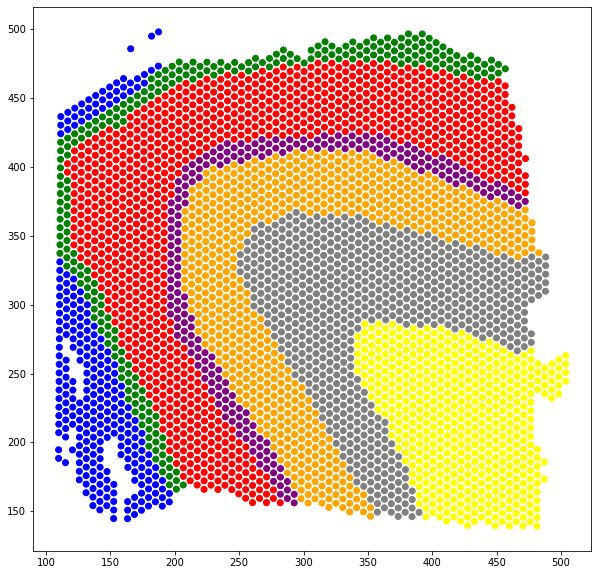

In [7]:
xs = combined_df['imagerow'].values
ys = combined_df['imagecol'].values
colors = combined_df['color'].values
plt.figure(figsize=(10,10))
plt.scatter(xs,ys,c=colors)
plt.savefig('manual_annotations.png',format='png',dpi=1000)

In [7]:
layers_dfs = []
inverse_layers_dfs = []
for i in sorted(combined_df['label'].unique()):
    layers_dfs.append(combined_df[combined_df['label']==i])
    inverse_layers_dfs.append(combined_df[combined_df['label']!=i])


# Same cluster cosine similarity

In [16]:
layers_dfs[0][pc_s.columns.values].values.shape

(689, 15)

In [8]:
pairwise_cosine_similarity = {}
for i in range(len(layers_dfs)):
    for j in range(len(layers_dfs)):
        cx = layers_dfs[i]['label'].unique()[0]
        cy = layers_dfs[j]['label'].unique()[0]
        if (cx,cy) not in pairwise_cosine_similarity:

            princs_i = layers_dfs[i][pc_s.columns.values].values
            princs_j = layers_dfs[j][pc_s.columns.values].values
            similarity = cosine_similarity(princs_i,princs_j)
            similarity = pd.DataFrame(similarity)
            # similarity.to_csv(outputbasefolder+'/_'+'layer_'+str(i)+'_layer_'+str(j)+'_cosine_similarity.csv')
            pairwise_cosine_similarity[(cx,cy)] = similarity

In [9]:
one_vs_all_cosine_similarity = {}
for i in range(len(layers_dfs)):
    cx = layers_dfs[i]['label'].unique()[0]

    princs_i = layers_dfs[i][pc_s.columns.values].values
    princs_j = inverse_layers_dfs[i][pc_s.columns.values].values
    similarity = cosine_similarity(princs_i,princs_j)
    similarity = pd.DataFrame(similarity)
    # similarity.to_csv(outputbasefolder+'/'+'one_vs_all_cosine_similarity_layer_'+str(i)+'.csv')
    one_vs_all_cosine_similarity[cx] = similarity

In [12]:
cos_sim_df = pd.DataFrame(columns=['layer_no','layer_1_count','layer_1_avg','others_count','others_avg','distance'])
for i in range(len(layers_dfs)):
    cx = layers_dfs[i]['label'].unique()[0]

    layer_i_cosine_similarity = pairwise_cosine_similarity[(cx,cx)].values.mean()
    layer_other_cosine_similarity = one_vs_all_cosine_similarity[cx].values.mean()

    # print('Layer '+str(i+1)+' cosine similarity: '+str(layer_i_cosine_similarity))
    # print('Layer '+str(i+1)+' one vs all cosine similarity: '+str(layer_other_cosine_similarity))
    avrage = layer_i_cosine_similarity-layer_other_cosine_similarity
    # print("distance: "+str(avrage))

    cos_sim_df.loc[i] = [cx,len(layers_dfs[i]),layer_i_cosine_similarity,len(inverse_layers_dfs[i]),layer_other_cosine_similarity,avrage]
cos_sim_df.to_csv(outputbasefolder+'/cosine_similarity_onv_vs_all_33538_genes.csv')
cos_sim_df

,layer_no,layer_1_count,layer_1_avg,others_count,others_avg,distance
0,L1,273,0.840846,3338,0.852625,-0.011779
1,L2,253,0.934316,3358,0.895298,0.039017
2,L3,989,0.951640,2622,0.890542,0.061098
3,L4,218,0.936771,3393,0.899134,0.037637
4,L5,673,0.932630,2938,0.892392,0.040238
5,L6,692,0.886211,2919,0.878989,0.007223
6,WM,513,0.848407,3098,0.756880,0.091526


In [13]:
cos_sim_df = pd.DataFrame(columns=['layer_no_1', 'layer_1_count', 'layer_1_avg', 'layer_no_2',
                          'layer_2_count', 'layer_2_avg', 'inter_layer_average_cos_sim', 'distance'])
for (i, j) in pairwise_cosine_similarity:
    layer_i_cosine_similarity = pairwise_cosine_similarity[(i,i)].values.mean()
        
    layer_other_cosine_similarity = pairwise_cosine_similarity[(j,j)].values.mean()

    layer_i_j_cosine_similarity = pairwise_cosine_similarity[(i, j)].values.mean()
    avrage = layer_i_cosine_similarity-layer_other_cosine_similarity
    # print("distance: "+str(avrage))

    # cos_sim_df.loc[i] = [i+1,len(layers_dfs[i]),layer_i_cosine_similarity,j+1,len(layers_dfs[j]),layer_other_cosine_similarity,layer_i_j_cosine_similarity,avrage]
    new_row = pd.DataFrame({'layer_no_1': i, 'layer_1_count': len(pairwise_cosine_similarity[(i,i)]), 'layer_1_avg': layer_i_cosine_similarity, 'layer_no_2': j, 'layer_2_count': len(
        pairwise_cosine_similarity[(j,j)]), 'layer_2_avg': layer_other_cosine_similarity, 'inter_layer_average_cos_sim': layer_i_j_cosine_similarity, 'distance': avrage},index=[i+'_'+j])
    cos_sim_df = pd.concat([cos_sim_df, new_row], axis=0,ignore_index=True)
cos_sim_df.to_csv(outputbasefolder+'/cosine_similarity_pairwise_33538_genes.csv')
cos_sim_df


,layer_no_1,layer_1_count,layer_1_avg,layer_no_2,layer_2_count,layer_2_avg,inter_layer_average_cos_sim,distance
0,L1,273,0.840846,L1,273,0.840846,0.840846,0.0
1,L1,273,0.840846,L2,253,0.934316,0.883253,-0.09347
2,L1,273,0.840846,L3,989,0.95164,0.888833,-0.110794
3,L1,273,0.840846,L4,218,0.936771,0.880346,-0.095925
4,L1,273,0.840846,L5,673,0.93263,0.876751,-0.091784
5,L1,273,0.840846,L6,692,0.886211,0.854049,-0.045366
6,L1,273,0.840846,WM,513,0.848407,0.722363,-0.007561
7,L2,253,0.934316,L1,273,0.840846,0.883253,0.09347
8,L2,253,0.934316,L2,253,0.934316,0.934316,0.0
9,L2,253,0.934316,L3,989,0.95164,0.940594,-0.017324


In [13]:
label_map = {
    0: 'WM',
    6: 'L1',
    5: 'L2',
    4: 'L3',
    3: 'L4',
    2: 'L5',
    1: 'L6',
    -1: 'undetected',
}
combined_df['label'] = combined_df['label'].map(label_map)

In [14]:
combined_df

,imagerow,imagecol,manual_annotation,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,color
AAACAAGTATCTCCCA-1,381.098123,440.639079,L3,L3,-4.518934,0.186934,-1.579811,-0.502101,0.671348,0.641350,0.321643,-0.982915,-1.298658,-0.819136,0.939768,-0.435809,-0.621682,0.595509,0.588482,red
AAACAATCTACTAGCA-1,126.327637,259.630972,L1,L1,-1.633397,-3.833832,1.368849,2.258932,1.818374,0.790188,-1.387884,-3.464785,0.880539,0.049468,2.961622,-1.827578,0.877444,0.893352,0.614336,blue
AAACACCAATAACTGC-1,427.767792,183.078314,WM,WM,21.552655,2.453866,0.134693,0.218036,2.672315,1.342351,0.246729,-0.537452,-0.812352,-0.338191,0.802174,-1.181476,1.924210,-0.287476,3.135437,yellow
AAACAGAGCGACTCCT-1,186.813688,417.236738,L3,L3,-3.053900,-0.924409,-3.857269,-1.544023,-0.877575,0.376134,-0.406179,0.207248,-0.451980,0.270314,-2.740054,0.360953,-0.293267,-0.700714,-0.420126,red
AAACAGCTTTCAGAAG-1,341.269139,152.700275,L5,L6,-1.619257,1.034808,1.159368,-2.779512,0.737436,-0.835721,-0.300298,1.180892,-0.731906,-4.153623,-0.342099,-1.206988,-0.484086,-1.136119,1.612747,orange
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,422.862301,254.410450,WM,WM,23.973508,5.234209,-0.878509,2.523938,2.460883,2.013336,-0.802269,-1.420241,1.247154,-0.523637,-0.631024,-0.214482,1.110847,-1.917133,-1.716933,yellow
TTGTTTCATTAGTCTA-1,433.393354,217.146722,WM,WM,19.305907,-4.021886,0.445819,0.347937,-0.672546,0.063651,-1.265542,-1.899604,-1.675924,1.196274,0.356815,-3.379339,0.588748,1.205863,1.834935,yellow
TTGTTTCCATACAACT-1,352.430255,208.415849,L6,L6,6.174339,-0.367159,-0.959408,-0.629316,-2.005205,-3.275628,0.266814,1.005154,1.078512,-2.839365,0.991722,-1.237173,2.573723,1.405452,1.283472,grey
TTGTTTGTATTACACG-1,503.735391,250.720081,WM,WM,10.519546,-1.084939,1.415915,-1.424585,-0.918063,-1.170070,2.940803,1.221382,-0.074671,2.889727,-0.209896,1.586728,1.919082,0.681071,-3.205603,yellow


In [15]:

combined_df['color'] = combined_df['label'].map(color_map)
combined_df['color'] = combined_df['color'].fillna('black')
combined_df

,imagerow,imagecol,manual_annotation,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,color
AAACAAGTATCTCCCA-1,381.098123,440.639079,L3,L3,-4.518934,0.186934,-1.579811,-0.502101,0.671348,0.641350,0.321643,-0.982915,-1.298658,-0.819136,0.939768,-0.435809,-0.621682,0.595509,0.588482,red
AAACAATCTACTAGCA-1,126.327637,259.630972,L1,L1,-1.633397,-3.833832,1.368849,2.258932,1.818374,0.790188,-1.387884,-3.464785,0.880539,0.049468,2.961622,-1.827578,0.877444,0.893352,0.614336,blue
AAACACCAATAACTGC-1,427.767792,183.078314,WM,WM,21.552655,2.453866,0.134693,0.218036,2.672315,1.342351,0.246729,-0.537452,-0.812352,-0.338191,0.802174,-1.181476,1.924210,-0.287476,3.135437,yellow
AAACAGAGCGACTCCT-1,186.813688,417.236738,L3,L3,-3.053900,-0.924409,-3.857269,-1.544023,-0.877575,0.376134,-0.406179,0.207248,-0.451980,0.270314,-2.740054,0.360953,-0.293267,-0.700714,-0.420126,red
AAACAGCTTTCAGAAG-1,341.269139,152.700275,L5,L6,-1.619257,1.034808,1.159368,-2.779512,0.737436,-0.835721,-0.300298,1.180892,-0.731906,-4.153623,-0.342099,-1.206988,-0.484086,-1.136119,1.612747,grey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,422.862301,254.410450,WM,WM,23.973508,5.234209,-0.878509,2.523938,2.460883,2.013336,-0.802269,-1.420241,1.247154,-0.523637,-0.631024,-0.214482,1.110847,-1.917133,-1.716933,yellow
TTGTTTCATTAGTCTA-1,433.393354,217.146722,WM,WM,19.305907,-4.021886,0.445819,0.347937,-0.672546,0.063651,-1.265542,-1.899604,-1.675924,1.196274,0.356815,-3.379339,0.588748,1.205863,1.834935,yellow
TTGTTTCCATACAACT-1,352.430255,208.415849,L6,L6,6.174339,-0.367159,-0.959408,-0.629316,-2.005205,-3.275628,0.266814,1.005154,1.078512,-2.839365,0.991722,-1.237173,2.573723,1.405452,1.283472,grey
TTGTTTGTATTACACG-1,503.735391,250.720081,WM,WM,10.519546,-1.084939,1.415915,-1.424585,-0.918063,-1.170070,2.940803,1.221382,-0.074671,2.889727,-0.209896,1.586728,1.919082,0.681071,-3.205603,yellow


<Figure size 360x720 with 0 Axes>

<Figure size 360x720 with 0 Axes>

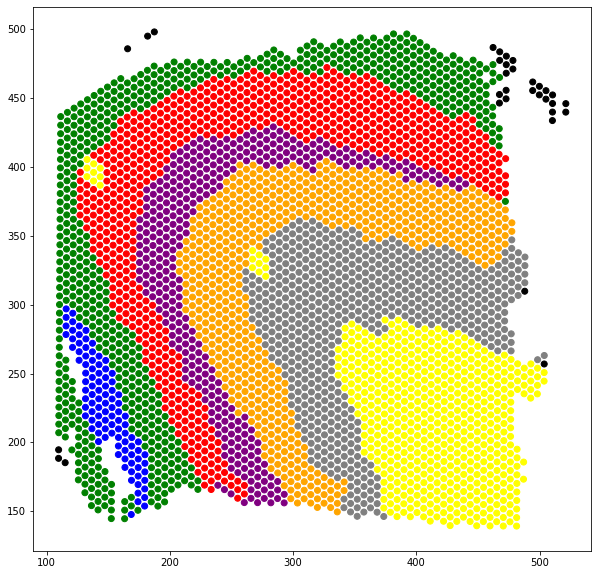

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(combined_df['imagerow'],combined_df['imagecol'],c=combined_df['color'])
# plt.savefig('manual_annotations.png')

(3611, 2)


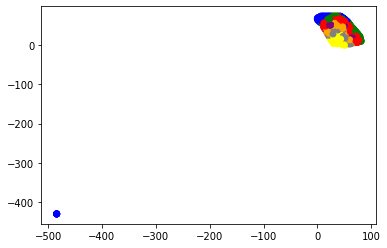

In [19]:
from sklearn.metrics.pairwise import euclidean_distances
import math
def rotate(p, origin=(0, 0), degrees=0):
    '''
    function to rotate 2d coordinate system at 'origin' anticlockwise
    '''
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

xy_arr = combined_df[['imagerow','imagecol']]
xy = np.array(xy_arr)

#number of spots
len_adata = len(xy)

# all pair distance between coordinates
dist_mat = euclidean_distances(xy,xy) #dist_mat[i][j] = sqr(dist) between i and j cells

def find_nearest_six(x):
  '''
  find nearest 6 neighbours of a spot
  '''
  neighbors = dist_mat[x]
  ids = [i for i in range(len_adata)]
  zipped_lists = zip(neighbors, ids)
  sorted_pairs = sorted(zipped_lists)
  return [y for (_,y) in sorted_pairs[1:7]]

#find the center point of all spots
left_x = 1e10
left_y = 1e10
right_x = -1e9
right_y = -1e9
for i in xy:
    left_x = min(left_x, i[0] - 50)
    left_y = min(left_y, i[1] - 50)
    right_x = max(right_x, i[0] + 50)
    right_y = max(right_y, i[1] + 50)
    
left_border_x = left_x + 50
left_border_y = left_y + 50
right_border_x = right_x - 50
right_border_y = right_y - 50

#rotate the spots' coordinate system
xy = rotate(xy, ((left_border_x  + right_border_x) / 2, (left_border_y + right_border_y) / 2), -90)

d = {}
for i in range(len(xy)):
  for j in find_nearest_six(i):
    x = d.get(dist_mat[i][j], 0)
    d[dist_mat[i][j]] = x + 1

# four neighbours of each spot
g_right = [-1] * (len(xy) + 1)
g_down = [-1] * (len(xy) + 1)
g_left = [-1] * (len(xy) + 1)
g_up = [-1] * (len(xy) + 1)

min_dist = min(d)

def make_edges(i):
  '''
  add edges with neighbourhood of a spot from coordinates 
  '''
  for j in find_nearest_six(i):
    angle_deg = 90
    if xy[i][0] - xy[j][0] != 0:
      angle_deg = math.degrees(math.atan((xy[i][1] - xy[j][1]) / (xy[i][0] - xy[j][0])))

    if angle_deg < 1 and angle_deg > -1 and xy[j][0] > xy[i][0] and dist_mat[i][j] < min_dist + 1:
      # make right edge
      g_right[i] = j
      g_left[j] = i

    elif angle_deg < 1 and angle_deg > -1 and xy[j][0] < xy[i][0] and dist_mat[i][j] < min_dist + 1:
      # make left edge
      g_left[i] = j
      g_right[j] = i

    elif angle_deg < 62 and angle_deg > 58 and xy[j][1] < xy[i][1] and dist_mat[i][j] < min_dist + 1:
      # make down edge
      g_down[i] = j
      g_up[j] = i
    elif angle_deg < 62 and angle_deg > 58 and xy[j][1] > xy[i][1] and dist_mat[i][j] < min_dist + 1:
      # make up edge
      g_up[i] = j
      g_down[j] = i


mn_dst = 1e30
mx_dst = 0
for i in range(len(xy)):
  if g_left[i] != -1:mx_dst = max(mx_dst, dist_mat[i][g_left[i]])
  if g_right[i] != -1:mx_dst = max(mx_dst, dist_mat[i][g_right[i]])
  if g_up[i] != -1:mx_dst = max(mx_dst, dist_mat[i][g_up[i]])
  if g_down[i] != -1:mx_dst = max(mx_dst, dist_mat[i][g_down[i]])

#add neighbours for each spot
for i in range(len(xy)):
  make_edges(i)

def bfs(s:int):
  '''
  run bfs on neighbourhood graph to get a maximal connected pixelated form of graph
  '''
  vis = [False] * (len(xy) + 1)
  spot_xy = [[0,0]] * len(xy)
  q = []
  q.append(s)
  spot_xy[s] = [500, 500]
  vis[s] = True
  while len(q) != 0:
    u = q[0]
    cur_x = spot_xy[u][0]
    cur_y = spot_xy[u][1]
    q.pop(0)
    if g_right[u] != -1:
      v = g_right[u]
      if vis[v] == False:
        q.append(v)
        vis[v] = True
        spot_xy[v] = [cur_x + 1, cur_y]
    if g_left[u] != -1:
      v = g_left[u]
      if vis[v] == False:
        q.append(v)
        vis[v] = True
        spot_xy[v] = [cur_x - 1, cur_y]
    if g_up[u] != -1:
      v = g_up[u]
      if vis[v] == False:
        q.append(v)
        vis[v] = True
        spot_xy[v] = [cur_x, cur_y + 1]
    if g_down[u] != -1:
      v = g_down[u]
      if vis[v] == False:
        q.append(v)
        vis[v] = True
        spot_xy[v] = [cur_x, cur_y - 1]
  return spot_xy

# pixelated form of graph
spot_xy = bfs(1) # passing 1 is not a good way, as there can be many components of the graph

# some spots are not visited, they are remains at (0, 0) as they were initialized
bad = []
#others' are good
good = []
for i in range(len(xy)):
  if spot_xy[i][0] == 0 or spot_xy[i][1] ==  0:
    bad.append(i)
  else:
    good.append(i)

spot_xy_grid = spot_xy.copy()
color_list  = combined_df['color'].to_numpy()
# delete the bad spots from pixalated form of graph
spot_xy_grid = np.delete(spot_xy_grid, obj = bad, axis = 0)
# color_list = np.delete(color_list, obj = bad)
min_xy = spot_xy_grid.min(axis = 0)
spot_xy_grid = spot_xy_grid - min_xy
# move origin to (0,0)
spot_xy_minus = spot_xy - min_xy
print(spot_xy_minus.shape)
plt.scatter(spot_xy_minus[:,0],spot_xy_minus[:,1],c=color_list)

colorlist: (3611,)
colorlist: (3611,)
Spotxy minus: (3611, 2)


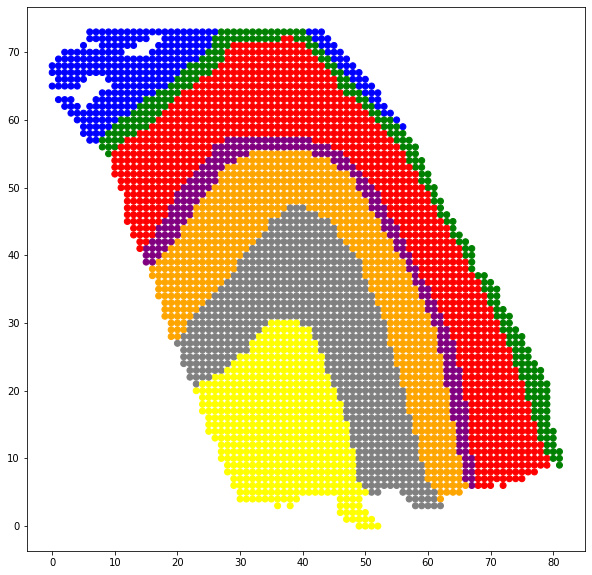

In [21]:
color_list  = combined_df['color'].to_numpy()
# delete the bad spots from pixalated form of graph
print("colorlist:",color_list.shape)
# color_list = np.delete(color_list, obj = bad)
print("colorlist:",color_list.shape)
print("Spotxy minus:",spot_xy_minus.shape)
pos_ind = np.array([i[0] >= 0 and i[1] >=0 for i in spot_xy_minus])
plt.figure(figsize=(10,10))
minor_ticks_x = np.arange(spot_xy_minus[:,0].min()-0.5, spot_xy_minus[:,0].max()+0.5, 1)
minor_ticks_y = np.arange(spot_xy_minus[:,1].min()-0.5, spot_xy_minus[:,1].max()+0.5, 1)
# plt.gca().set_xticks(minor_ticks_x, minor=True)
# plt.gca().set_yticks(minor_ticks_y, minor=True)
# plt.gca().grid(which='minor')
plt.scatter(spot_xy_minus[pos_ind,0],spot_xy_minus[pos_ind,1],c=color_list[pos_ind])
# plt.savefig('manual_annotation_after_pixelation.eps', format='eps', dpi=1000)
plt.savefig('manual_annotation_after_pixelation.png', format='png', dpi=1000)